In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Weighted Grassmann clustering - overview

In this notebook, we will implement a clustering algorithm for data on the Grassmannian, where the objective function is weighted for each input data direction.

Orthonormal bases are distributed on the Grassmann manifold. One example is the evaluation of phase coherence in functional neuroimaging data, where instantaneous phase coherence between a set of regions is calculated for each time point $i$ and collected in the matrix $\mathbf A_i$ with elements $A_{i,j,j'}=\cos\left(\theta_{i,j}-\theta_{i,j'}\right)$ for $j,j'\in\{1,\ldots,n\}$, where $\theta_{i,j}$ is the phase of region $j$ at time point $i$. Such a phase coherence matrix can be decomposed into two vectors corresponding to the sine $\mathbf s_i=\sin\boldsymbol\theta_i$ and cosine $\mathbf c_i=\cos\boldsymbol\theta_i$ of the phase vector using the angle difference identity (omitting the time-notation) $\mathbf A=\mathbf c\mathbf c^\top + \mathbf s \mathbf s^\top$, revealing that the phase coherence matrix has rank $q=2$. The orthonormal basis $\mathbf U\in\mathbb R^{p\times q}$ from $\left[\mathbf U,\boldsymbol \Sigma,\mathbf V\right] = \mathrm{SVD}\left(\left[\mathbf c,\mathbf s\right]\right)$ corresponds to the two eigenvectors of $\mathbf A$ corresponding to non-zero eigenvalues and thus encapsulates all information in the phase coherence matrix. The orthonormal basis $\mathbf U$ is distributed on the Grassmann manifold and the pool of orthonormal bases, say, over time points, can be clustered using Grasmmann clustering by Gruber & Theis, 2006 (https://ieeexplore.ieee.org/abstract/document/7071681)

However, the eigenvalues of the phase coherence matrix $\mathbf A$ (corresponding to the singular values squared, i.e., $\lambda_l=\sigma_l^2, \quad l\in\{1,\ldots,q\}$) are not considered in the clustering algorithm. In the following, we will implement a clustering algorithm for data on the Grassmannian, where the objective function is weighted for each input data direction.

#### Points on the Grassmannian

Each data point is composed of $q$ eigenvectors $\mathbf U\in\mathbb R^{p\times q}$, where $p$ is the number of regions and $q$ is the rank of the phase coherence matrix. The Grassmannian is the set of all $q$-dimensional subspaces of $\mathbb R^p$ and can be represented by the set of all orthonormal bases $\mathbf U\in\mathbb R^{p\times q}$. Each point can be thought of as spanning a plane. Let's say we have a unit 2D coherence matrix and find its eigendecomposition:

In [2]:
#make a unit matrix
A = np.array([[1,1],[1,1]])
L,U = np.linalg.eig(A)
U

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

Let's visualize the orthonormal basis $\mathbf U$

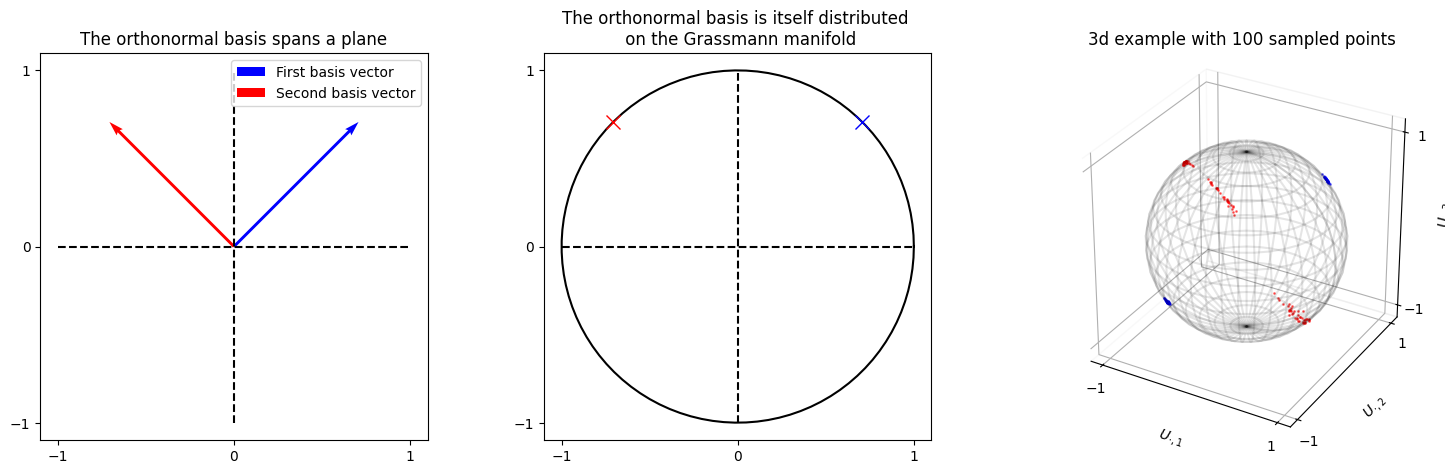

In [4]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1,3, height_ratios=[1], width_ratios=[1,1,1], wspace=0.3)
ax0 = fig.add_subplot(gs[0,0])
A = np.array([[1,1],[1,1]])
L,U = np.linalg.eig(A)
ax0.quiver(0, 0, U[0,0], U[1,0], angles='xy', scale_units='xy', scale=1, color='b')
ax0.quiver(0, 0, U[0,1], U[1,1], angles='xy', scale_units='xy', scale=1, color='r')
ax0.set_xlim(-1.1, 1.1)
ax0.set_ylim(-1.1, 1.1)
ax0.set_xticks([-1,0,1])
ax0.set_yticks([-1,0,1])
ax0.vlines(0, -1, 1, color='k', linestyles='dashed')
ax0.hlines(0, -1, 1, color='k', linestyles='dashed')
ax0.set_aspect('equal')
ax0.set_title('The orthonormal basis spans a plane')
ax0.legend(['First basis vector','Second basis vector'])

# in the other subplot plot a unit circle with the points [0.7,0.7] and its orthogonal complement plotted
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
ax1 = fig.add_subplot(gs[0,1])
ax1.plot(x, y, color='k')
ax1.plot(0.707, 0.707,'x', color='b',markersize=10)
ax1.plot(-0.707, 0.707,'x', color='r',markersize=10)
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xticks([-1,0,1])
ax1.set_yticks([-1,0,1])
ax1.vlines(0, -1, 1, color='k', linestyles='dashed')
ax1.hlines(0, -1, 1, color='k', linestyles='dashed')
ax1.set_aspect('equal')
ax1.set_title('The orthonormal basis is itself distributed \n on the Grassmann manifold')

# draw sphere
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax2 = fig.add_subplot(gs[0,2], projection='3d')
ax2.plot_wireframe(x, y, z, color="k", alpha=0.1)
scale = 1
for i in range(100):
    #randomly select a sign
    phase_vector = np.array([1+np.random.random()*scale,1+np.random.random()*scale,1+np.random.random()*scale])
    coh_map = np.outer(np.cos(phase_vector),np.cos(phase_vector))+ np.outer(np.sin(phase_vector),np.sin(phase_vector))
    _,U_noise = np.linalg.eig(coh_map)
    ax2.scatter([U_noise[0,0]],[U_noise[1,0]],[U_noise[2,0]], color='b', s=1, alpha=0.5)
    ax2.scatter([U_noise[0,1]],[U_noise[1,1]],[U_noise[2,1]], color='r', s=1, alpha=0.5)

# remove ticks
ax2.set_xticks([-1,1])
ax2.set_yticks([-1,1])
ax2.set_zticks([-1,1])
ax2.set_aspect('equal')
ax2.set_xlabel(r'$U_{\cdot,1}$',labelpad=0.01)
ax2.set_ylabel(r'$U_{\cdot,2}$',labelpad=0.01)
ax2.set_zlabel(r'$U_{\cdot,3}$',labelpad=0.01)

ax2.tick_params(axis="y", pad=0.01)
ax2.tick_params(axis="z", pad=0.01)
ax2.tick_params(axis="x", pad=0.01)

# keep the three main axes but remove the gray area in the middle of the 3d plot
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.set_title('3d example with 100 sampled points');

Some general properties of an orthonormal basis:

1. Each vector is a unit vector, i.e., $\mathbf u_l^\top\mathbf u_l=1$ and thus located on the (surface of the) unit sphere.
2. Each vector represents an axis and is thus sign-invariant. The sign of the vector can be flipped without changing the axis and the representation.
3. The vectors are pairwise orthogonal, i.e., $\mathbf u_l^\top\mathbf u_l'=0$ for $l\neq l'$.

These are exactly the properties of the Grassmannian manifold. All of the above requirements can be summarized as the requirement $\mathbf X^\top \mathbf X = \mathbf I_q$ and thus we can define the Grassmann manifold:

$\textrm{Gr}(p,q)=\{\mathbf X|\mathbf X^\top \mathbf X = \mathbf I_q\}$

In the right-most plot above we have sampled 100 points from the Grassmannian $\textrm{Gr}(3,2)$ by adding a random value to each element of a unitary phase vector $\boldsymbol\theta=\left[1,1,1\right]$, then computing the phase coherence matrix and the eigendecomposition. The reason for showing this one in 3d is that $\textrm{Gr}(2,2)$ is highly limited - points can only exist at $\left[1,0\right]$, $\left[0,1\right]$, $\left[0.7,0.7 \right]$ and their sign-combinations (if you doubt this, try computing the eigendecomposition of various 2d phase coherence matrices). But watch what happened in the 3d example - variance was added to the red points but not really the blue ones. Why? Let's look at the eigendecomposition of A again, this time also looking at the eigenvalues:

In [5]:
#make an array
A = np.array([[1,1,1],[1,1,1],[1,1,1]])
L,U = np.linalg.eig(A)
print(U)
print(L)

[[-0.81649658  0.57735027  0.        ]
 [ 0.40824829  0.57735027 -0.70710678]
 [ 0.40824829  0.57735027  0.70710678]]
[-2.22044605e-16  3.00000000e+00  0.00000000e+00]


There is only one non-zero eigenvalue! Thus only the blue point really matters - the red point could be anywhere, as long as it's orthogonal to the blue point. In 3D, this corresponds to the great circle orthogonal to the blue point. 

<Axes3D: title={'center': 'Great circle orthogonal to\n[0.57735027 0.57735027 0.57735027]'}>

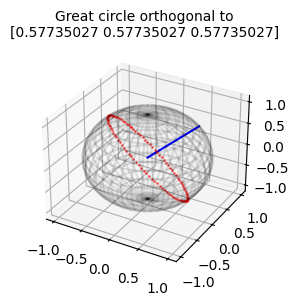

In [11]:
def great_circle(x,num_points):
    x = x/np.linalg.norm(x) #ensure unit vector
    v = np.random.randn(3) #random point on circle
    v = v/np.linalg.norm(v) 
    v = v - np.dot(v,x)*x
    v = v/np.linalg.norm(v)
    w = np.cross(x,v)
    theta = np.linspace(0,2*np.pi,num_points)
    u_all = np.zeros((3,num_points))
    for n in range(num_points):
        u_all[:,n] = np.cos(theta[n])*v+np.sin(theta[n])*w
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111, projection='3d')
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    xx = np.cos(u)*np.sin(v)
    yy = np.sin(u)*np.sin(v)
    zz = np.cos(v)
    ax.plot_wireframe(xx, yy, zz, color="k", alpha=0.1)
    for n in range(num_points):
        ax.scatter(u_all[0,n],u_all[1,n],u_all[2,n], color='r', s=1, alpha=0.5)
    ax.set_title('Great circle orthogonal to\n'+str(x),fontsize=10)
    # add the input vector on the figure
    ax.plot([0, x[0]], [0, x[1]], [0, x[2]], color='b')
    return ax

great_circle(np.array([0.577,0.577,0.577]),100)

The Grassmann manifold does not treat eigenvalues at all, and thus, both eigenvectors carry equal weight, even if their eigenvalues are highly different. In real human neuroimaging data, the eigenvalue for the leading eigenvector can explain anywhere between $50\%$ and $100\%$ of the variance, and thus, one solution for modeling phase coherence data is to just discard the trailing eigenvector completely and cluster such data based on statistical distributions on the Watson manifold (sign-symmetric unit hypersphere). The most simple solution is diametrical clustering. 

If we want to model both eigenvectors, albeit without the eigenvalues, we can do clustering on the Grassmann manifold. To do this we need a notion of distance on the grassmann manifold and a way to update centroids in a K-means framework. The typical way a K-means algorithm works is 1) define initial centroids, 2) calculate the distance between each point and each centroid, 3) assign each point to the closest centroid, 4) update the centroids by averaging the points assigned to each centroid. Then repeat 2-4. 

#### Distance on the Grassmann manifold

The distance between two subspaces is measured in terms of principal angles  $\phi_1,\ldots,\phi_q\in\left[0,\pi/2\right]$ between principal vectors (the eigenvectors of the phase coherence matrix) of the two subspaces. Let's denote two subspaces $\mathbf U_1$ and $\mathbf U_2$, respectively. The principal angles are then the angle between each vector of $\mathbf U_1$ and each vector of $\mathbf U_2$. This problem, it turns out, is very easily solved using the SVD:

$$\mathbf U_1^\top \mathbf U_2 = \mathbf U_{pa} \boldsymbol\Sigma_{pa}\mathbf V_{pa}^\top$$

where $\sigma_1\geq,\ldots,\geq\sigma_q$ are the singular values, where $0\leq \sigma_l \leq 1$ since $\mathbf U_1$ and $\mathbf U_2$ have orthonormal columns. The principal angles are then defined as 

$$\cos\phi_l=\sigma_l,\quad l=1,\ldots,q$$

Note that $\mathbf U_{pa}$ and $\mathbf V_{pa}$ are the principal vectors that span the "midpoint" between $\mathbf U_1$ and $\mathbf U_2$ - these can be discarded for now since we're (at the moment) only interested in the distance given by the principal angles. 

The distance may then be defined in a multitude of ways given the principal angles (see http://helper.ipam.ucla.edu/publications/glws1/glws1_15465.pdf, slide 10). The most common solution is the norm of the principal angles, also called the *geodesic* distance: 

$$d_{Gr(p,q)}(\mathbf U_1,\mathbf U_2)=\sqrt{\sum_{l=1}^q \phi_l^2}$$

In the case where $\mathbf U_1$ and $\mathbf U_2$ are not of the same subspace dimensionality - say, $q_1 \neq q_2$, the chordal distance, also called the projection F-norm may be used - this one is used in the Grassmann clustering algorithm by Gruber and Theis (https://ieeexplore.ieee.org/abstract/document/7071681):

\begin{align}
d_{Gr(p,q)}(\mathbf U_1,\mathbf U_2)&=\frac{1}{\sqrt{2}}||\mathbf U_1\mathbf U_1^\top - \mathbf U_2\mathbf U_2^\top||_F\\
&= \frac{1}{\sqrt{2}}\textrm{tr}\left(\mathbf U_1\mathbf U_1^\top - \mathbf U_2\mathbf U_2^\top\right)^\top\left(\mathbf U_1\mathbf U_1^\top - \mathbf U_2\mathbf U_2^\top\right)\\
&= \frac{1}{\sqrt{2}}\left[\textrm{tr}\left(\mathbf U_1\mathbf U_1^\top\right)+\textrm{tr}\left(\mathbf U_2\mathbf U_2^\top\right) - 2\textrm{tr}\left(\mathbf U_1\mathbf U_1^\top\mathbf U_2\mathbf U_2^\top\right)\right]\\
&= \frac{1}{\sqrt{2}}\left[2q - 2 ||\mathbf U_1^\top \mathbf U_2||_F^2\right]
\end{align}

The chordal distance is both similar and different to the geodesic distance. Similar, because a high value in one should mean a high value in the other. Different, because the chordal distance involves projecting the orthonormal bases into the space of symmetric matrices, e.g., $\mathbf U_1 \mathbf U_1^\top$. The projection is thus no longer on the Grassmann manifold - this detail is only important when considering a probabilistic extension to Grassmann clustering, which could then be based on a Singular Wishart distribution. Note also that the extra derivations from the chordal distance function are necessary to avoid actually computing $\mathbf U_1 \mathbf U_1^\top$ and $\mathbf U_2 \mathbf U_2^\top$ since, if $p$ is high, this can be prohibitively memory-expensive.

Below a simple implementation of the two distance functions

In [7]:
def chordal_distance(U,C):
    """"
    U: orthonormal bases of size (Nxpxq), where N is number of observations, p is the number of features and q is the subspace dimensionality
    C: Centroid of the subspace of size (Kxpxq), where K is number of centroids/states
    returns: distance of size (NxK)
    """
    dis = 1/np.sqrt(2)(2*U.shape[-1]-2*np.linalg.norm(np.swapaxes(U[:,None],-2,-1)@C[None],axis=(-2,-1)))
    return dis

def geodesic_distance(U,C):
    """"
    U: orthonormal bases of size (Nxpxq), where N is number of observations, p is the number of features and q is the subspace dimensionality
    C: Centroid of the subspace of size (Kxpxq), where K is number of centroids/states
    returns: distance of size (NxK)
    """
    S = np.linalg.svd(np.swaxaes(U[:,None],-2,-1)@C[None],compute_uv=False)
    phi = np.arccos(np.clip(S, 0, 1)) #clip important because of numerical instabilities in the SVD
    dis = np.linalg.norm(phi)
    return dis

#### Averages on Grassmann manifold

We've defined distance functions - now we need to establish an average of the points assigned to the same centroid.

The averaging step is not as simple, however. As explained in the paper "Finding a subspace mean or median to fit your need" by Marrinan et al. (2014) (https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Marrinan_Finding_the_Subspace_2014_CVPR_paper.pdf), there are a bunch of different ways to define an average subspace, once again also dependent on whether the points are of the same subspace dimensionality $q$. The one that is the closest comparison to a euclidean mean, i.e., a "Riemannian" center of mass (Riemannian means something with Riemannian manifold, which is a generalization of spheres and Grassmann manifolds), is the Karcher mean (sidenote, Hermann Karcher is not too keen on this average being named after him https://arxiv.org/abs/1407.2087). The Karcher mean is the solution to the minimization of the (squared) geodesic distance defined above, when summed over data points. However, as explained by Marrinan and colleagues, the Karcher mean does not have a closed-form solution and thus requires iterative optimization.

Instead we will look at two other ways to define an average subspace: the extrinsic manifold mean and the flag mean. Do not be fooled by their names: they are both in fact more like a median than a mean. The extrinsic manifold is the solution to the minimization of the sum of the (squared) chordal distances between the mean and the data points, when the subspace dimensionality of these are equal. 

$$\left(\sum_{i=1}^N \mathbf U_i\mathbf U_i^\top\right)\mathbf U_{ex}=\boldsymbol\Lambda\mathbf U_{ex}$$

This corresponds to the first $q$ eigenvectors of the average projection of data points. 

The flag mean is the generalization of the extrinsic manifold mean to instances, where the subspace dimensionality differs over data points. The derivations may be found in the Marrinan-paper, but the solution to the flag mean is rather simple: Stack all of the points horizontally:

$$\left[\mathbf U \right] = \left[\mathbf U_1,\mathbf U_2,\ldots,\mathbf U_N\right]$$

where we remember that each point is a $(pxq)$ orthonormal matrix. Then compute the SVD of this matrix:

$$\left[\mathbf U \right] = \mathbf U_{flag} \boldsymbol\Sigma_{flag} \mathbf V_{flag}^\top$$

The centroid is then the first $q$ left singular vectors corresponding to the highest singular values. The SVD is super cheap to evaluate, even for high dimensions, making the flag mean very attractable. When the subspace dimensionality does not change, the flag mean reduces to the extrinsic manifold mean, i.e., the SVD may also be used in the same way to calculate the extrinsic manifold mean.

#### Implementation

Let's implement two versions of Grassmann clustering: The one presented in Gruber & Theis, 2006, using the chordal distance measure and computing extrinsic manifold means for cluster centroids, and a new one using the geodesic distance function and the SVD from flag mean for updating centroids:

In [8]:
def grassmannian_clustering_gruber2006(X,K,max_iter=10000,tol=1e-16):
    """"
    Implementation of Grassmann clustering as in Gruber & Theis 2006 https://ieeexplore.ieee.org/abstract/document/7071681

    X: size (nxpxq), where n is the number of observations, p is the number of features and q is the subspace dimensionality
    K: number of clusters
    max_iter: maximum number of iterations
    tol: tolerance for convergence
    
    returns: cluster centers, objective function values, and cluster assignments
    """
    
    n,p,q = X.shape

    # initialize cluster centers using a normal distribution projected to the Grassmannian
    C = np.random.randn(K,p,q)
    for k in range(K):
        C[k] = C[k]@scipy.linalg.sqrtm(np.linalg.inv(C[k].T@C[k])) # project onto the Grassmannian

    # initialize counters
    iter = 0
    obj = []
    partsum = np.zeros((max_iter,K))
    while True:

        # "E-step" - compute the similarity between each matrix and each cluster center
        dis = 1/np.sqrt(2)(2*U.shape[-1]-2*np.linalg.norm(np.swapaxes(X[:,None],-2,-1)@C[None],axis=(-2,-1)))
        sim = -dis
        maxsim = np.max(sim,axis=1) # find the maximum similarity - the sum of this value is the objective function
        X_part = np.argmax(sim,axis=1) # assign each point to the cluster with the highest similarity
        obj.append(np.sum(maxsim))

        # check for convergence
        for k in range(K):
            partsum[iter,k] = np.sum(X_part==k)
        if iter>0:
            if all((partsum[iter-1]-partsum[iter])==0) or iter==max_iter or abs(obj[-1]-obj[-2])<tol:
                break
        
        # "M-step" - update the cluster centers
        for k in range(K):
            idx_k = X_part==k
            V = np.sum(X[idx_k]@np.swapaxes(X[idx_k],1,2),axis=0) #extrinsic manifold mean, may be computed more efficiently using the SVD
            L,U = scipy.sparse.linalg.eigsh(V,k=q,which='LM')
            C[k] = U
            
        iter += 1
    
    return C,obj,X_part

def grassmannian_clustering_geodesic_distance(X,K,max_iter=10000,tol=1e-16):
    """"
    Implementation of Grassmann clustering with a geodesic distance function and a SVD-based update rule

    X: size (nxpxq), where n is the number of observations, p is the number of features and q is the subspace dimensionality
    K: number of clusters
    max_iter: maximum number of iterations
    tol: tolerance for convergence
    
    returns: cluster centers, objective function values, and cluster assignments
    """

    
    n,p,q = X.shape
    
    # initialize cluster centers using a normal distribution projected to the Grassmannian
    C = np.random.randn(K,p,q)
    for k in range(K):
        C[k] = C[k]@scipy.linalg.sqrtm(np.linalg.inv(C[k].T@C[k])) # project onto the Grassmannian

    # initialize counters
    iter = 0
    obj = []
    partsum = np.zeros((max_iter,K))
    while True:

        # "E-step" - compute the similarity between each matrix and each cluster center
        _,S,_ = np.linalg.svd(np.swapaxes(X[:,None],-2,-1)@C[None],full_matrices=False)
        dis = np.linalg.norm(np.arccos(np.clip(S,-1,1)),axis=-1)
                
        sim = -dis
        maxsim = np.max(sim,axis=1) # find the maximum similarity - the sum of this value is the objective function
        X_part = np.argmax(sim,axis=1) # assign each point to the cluster with the highest similarity
        obj.append(np.sum(maxsim))

        # check for convergence
        for k in range(K):
            partsum[iter,k] = np.sum(X_part==k)
        if iter>0:
            if all((partsum[iter-1]-partsum[iter])==0) or iter==max_iter or abs(obj[-1]-obj[-2])<tol:
                break
        
        # "M-step" - update the cluster centers
        for k in range(K):
            idx_k = X_part==k
            V = np.reshape(np.swapaxes(X[idx_k],0,1),(p,np.sum(idx_k)*q))
            U,_,_ = scipy.sparse.linalg.svds(V,q)
            C[k] = U[:,:q]

        iter += 1
    
    return C,obj,X_part

### Weighted Grassmann clustering
#### Weighted chordal distance
Each datapoint has a set of $q$ eigenvalues associated with it. We can use these to weight the distance between points. Let's try the most simple idea, and let's look at the chordal distance function, where the eigenvalues $\boldsymbol\Lambda=\textrm{diag}(\lambda_{1},\ldots,\lambda_{q})$ have been included:

\begin{align}
d_{Gr(p,q)}(\mathbf U_1,\mathbf U_2,\boldsymbol\Lambda_1,\boldsymbol\Lambda_2)&=\frac{1}{\sqrt{2}}||\left(\mathbf U_1\boldsymbol\Lambda_1\right)\left(\mathbf U_1\boldsymbol\Lambda_1\right)^\top - \left(\mathbf U_2\boldsymbol\Lambda_2\right)\left(\mathbf U_2\boldsymbol\Lambda_2\right)^\top||_F\\
&= \frac{1}{\sqrt{2}}\textrm{tr}\left[\mathbf U_1\boldsymbol\Lambda_1\boldsymbol\Lambda_1\boldsymbol\Lambda_1\boldsymbol\Lambda_1\mathbf U_1^\top-\mathbf U_2\boldsymbol\Lambda_2\boldsymbol\Lambda_2\boldsymbol\Lambda_2\boldsymbol\Lambda_2\mathbf U_2^\top-2\mathbf U_1\boldsymbol\Lambda_1\boldsymbol\Lambda_1\mathbf U_1^\top\mathbf U_2\boldsymbol\Lambda_2\boldsymbol\Lambda_2\mathbf U_2^\top\right]\\
&= \frac{1}{\sqrt{2}} \left[\sum_{l=1}^q \lambda_{1l}^4+\sum_{l=1}^q \lambda_{2l}^4-2||\left(\mathbf U_1 \boldsymbol\Lambda_1\right)^\top\left(\mathbf U_2 \boldsymbol\Lambda_2\right)||_F^2\right]
\end{align}
There's no reason why this should not be a valid distance function where the eigenvalues are included, since the projection $\mathbf U_1 \mathbf U_1^\top$ is a projection away from the Grassmann to the space of symmetric matrices and the projection $\left(\mathbf U_1\boldsymbol\Lambda_1\right)\left(\mathbf U_1\boldsymbol\Lambda_1\right)^\top$ is also a projection to the space of symmetric matrices.

One could also envision including the eigenvalues for the geodesic distance function, but this is seemingly less straightforward.

#### Weighted flag mean

In completely similar fashion, the flag mean (which reduces to the weighted extrinsic manifold mean when the subspace dimensionalities are the same) can be weighted by the eigenvalues. First we stack the bases horizontally:

$$\left[\mathbf U \right] = \left[\mathbf U_1\boldsymbol\Lambda_1,\mathbf U_2\boldsymbol\Lambda_2,\ldots,\mathbf U_N\boldsymbol\Lambda_N\right]$$

The solution to the flag mean is then the SVD of this matrix:

$$\left[\mathbf U \right] = \mathbf U_{flag} \boldsymbol\Sigma_{flag} \mathbf V_{flag}^\top$$

The centroid is then composed of both the first $q$ left singular vectors AND the squared first $q$ singular values. Let's implement this function:

In [9]:
def weighted_grassmannian_clustering(X,X_weights,K,max_iter=10000,tol=1e-16):
    """"
    Weighted grassmannian clustering using the chordal distance function and a SVD-based update rule
    
    X: size (nxpxq), where n is the number of observations, p is the number of features and q is the subspace dimensionality
    X_weights: size (n,q), where n is the number of observations and q is the subspace dimensionality (corresponds to eigenvalues)
    K: number of clusters
    max_iter: maximum number of iterations
    tol: tolerance for convergence

    """
    
    n,p,q = X.shape

    # initialize cluster centers using a normal distribution projected to the Grassmannian
    C = np.random.randn(K,p,q)
    C_weights = np.ones((K,q))
    for k in range(K):
        C[k] = C[k]@scipy.linalg.sqrtm(np.linalg.inv(C[k].T@C[k])) # project onto the Grassmannian

    # initialize counters
    iter = 0
    obj = []
    partsum = np.zeros((max_iter,K))
    while True:
        # "E-step" - compute the similarity between each matrix and each cluster center
        dis = 1/np.sqrt(2)(np.sum(X_weights**4)+np.sum(C_weights**4)-2*np.linalg.norm(np.swapaxes((X*X_weights[:,None,:])[:,None],-2,-1)@(C*C_weights[:,None,:])[None],axis=(-2,-1)))
        sim = -dis
        maxsim = np.max(sim,axis=1) # find the maximum similarity - the sum of this value is the objective function
        X_part = np.argmax(sim,axis=1) # assign each point to the cluster with the highest similarity
        obj.append(np.sum(maxsim))

        # check for convergence
        for k in range(K):
            partsum[iter,k] = np.sum(X_part==k)
        if iter>0:
            if all((partsum[iter-1]-partsum[iter])==0) or iter==max_iter or abs(obj[-1]-obj[-2])<tol:
                break
        
        # "M-step" - update the cluster centers
        for k in range(K):
            idx_k = X_part==k
            V = np.reshape(np.swapaxes(X[idx_k]*X_weights[idx_k,None,:],0,1),(p,np.sum(idx_k)*q))
            U,S,_ = scipy.sparse.linalg.svds(V,q)
            C[k] = U[:,:q]
            C_weights[k] = S**2

        iter += 1
    
    return C,obj,X_part